In [ ]:
import pandas as pd

# load Dataset
df = pd.read_csv("Dataset.csv")


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


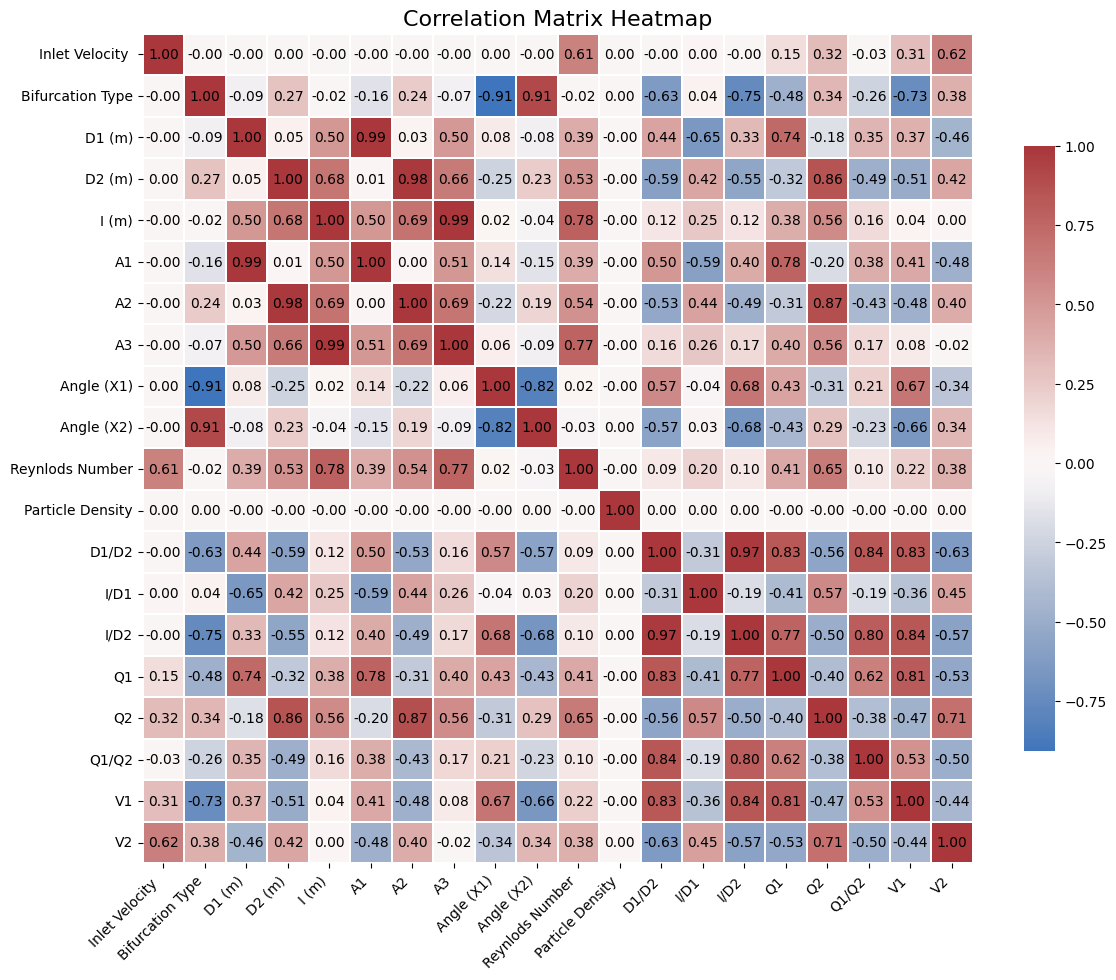

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns


corr_matrix = df.corr(numeric_only=True)

plt.figure(figsize=(12, 10))

sns.heatmap(
    corr_matrix, 
    annot=True,
    fmt=".2f",
    cmap="vlag",
    center=0,
    square=True, 
    linewidths=0.2, 
    cbar_kws={"shrink": 0.7},
    annot_kws={"color": "black"}
)
# Plot Correlation Matrix
plt.title("Correlation Matrix Heatmap", fontsize=16)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [ ]:

import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
from xgboost import XGBRegressor

warnings.filterwarnings("ignore")

# Feed X Without Output Columns
X = df.drop(columns=['Particle Density', 'D1/D2', 'I/D1', 'I/D2', 'Q1', 'Q2', 'Q1/Q2', 'V1', 'V2'])

# Set Output Columns
y = df["V1"]

y = y.loc[X.index]

# Split Test and Train Set In 20% - 80% With Random state 42 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Models Parameters
models_and_params = {
    "LinearRegression": {
        "model": LinearRegression(),
        "params": {
            "fit_intercept": [True, False]
        }
    },
    "RandomForestRegressor": {
        "model": RandomForestRegressor(),
        "params": {
            "n_estimators": [100, 200, 300, 400],
            "max_depth": [None, 10, 20, 30, 40],
            "min_samples_split": [2, 5, 8, 11],
            "min_samples_leaf": [1, 2, 3, 4, 5, 6],
        }
    }
}

models_and_params["XGBRegressor"] = {
    "model": XGBRegressor(objective='reg:squarederror', device='cuda'),
    "params": {
        "n_estimators": [100, 200, 300, 400],
        "max_depth": [3, 5, 7, 9, 11],
        "learning_rate": [0.001, 0.01, 0.1],
        "subsample": [0.4, 0.6, 0.8, 1.0]
    }
}

best_model = None
best_r2 = -np.inf
best_model_name = ""


for name, mp in models_and_params.items():
    print(f"\n Tuning {name}...")
    
    # Init Grid Search CV
    grid = GridSearchCV(
        estimator=mp["model"],
        param_grid=mp["params"],
        scoring='r2',
        cv=10,
        n_jobs=-1
    )

    
    # Start Train
    grid.fit(X_train, y_train)
    print(f"Best Parameters: {grid.best_params_}")
    print(f"Best Cross-Validation R²: {grid.best_score_:.4f}")

    # Evaluation RMSE, MAE, R2
    y_pred = grid.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R² on Test Set: {r2:.4f}")

    if r2 > best_r2:
        best_r2 = r2
        best_model = grid.best_estimator_
        best_model_name = name

print(f"\nBest Model: {best_model_name} with R² = {best_r2:.4f}")
